**Phillips-Ouliaris Cointegration Simple Crypto Pairs**

This script uses the Philip-Ouliaris cointegration method to find simple asset pair combinations from a given list of tickers.

Useful Resource for Cointegration Methods: https://bashtage.github.io/arch/doc/unitroot/unitroot_cointegration_examples.html

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import yfinance as yf
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from arch.unitroot.cointegration import phillips_ouliaris
from statsmodels.tsa.stattools import adfuller

from arch.unitroot.cointegration import engle_granger
import statsmodels.api as sm

In [2]:
class ticker_data:
    def __init__(self, ticker_x: list):
        """Tickers are passed as lists of strings."""
        self.ticker_x = ticker_x
        
        
    def get_data(self, ticker, period = "1mo", interval = "1d", actions = False):
        """Takes ticker as required parameter and returns historical price data. Uses parameters from yfinance. 
        Actions = False means that dividends and stock split data is not returned. All columns are adjusted prices. WARNING:
        DOESN'T WORK WITH HOURLY Intervals between cryptos and equities due to equities returning on the half hour"""
        x_tick = yf.Ticker(str(ticker))
        x_hist = x_tick.history(period = period, interval = interval, actions = actions)

        if x_hist.index.tzinfo is not None:
            x_hist.index = pd.to_datetime(x_hist.index).tz_convert("UCT")
            return x_hist
        else:
            return x_hist
        

    def get_returns(self, x_hist):
        """Takes historical data as required parameter."""
        x_ret = x_hist.pct_change().replace(np.inf, np.nan).dropna()
        return x_ret
    
    def price_df(self, period = "1mo", interval = "1d", actions = False, OHLC = "Close"):
        """Returns dataframe of prices"""
        indicator = None
        
        for ticker in self.ticker_x:
            x_hist = pd.DataFrame(self.get_data(ticker, period = period, interval = interval, actions = actions)[OHLC])
            x_hist.columns = [ticker + "_" + OHLC]
            
            if indicator == None:
                price_df = pd.DataFrame(x_hist)
                indicator = 1
            else:
                price_df = price_df.merge(x_hist, how="inner", left_index=True, right_index=True)
        
        return price_df
            
        
        
    def ret_df(self, period = "1mo", interval = "1d", actions = False, OHLC = "Close"):
        """Returns dataframe of returns"""
        
        indicator = None
        
        for ticker in self.ticker_x:
            x_hist = self.get_data(ticker, period = period, interval = interval, actions = actions)
            x_ret = pd.DataFrame(self.get_returns(x_hist)[OHLC])
            x_ret.columns = [ticker + "_" + OHLC]
            
            if indicator == None:
                ret_df = pd.DataFrame(x_ret)
                indicator = 1
            else:
                ret_df = ret_df.merge(x_ret, how="inner", left_index=True, right_index=True)
                
        return ret_df

    
class po_cointegration:
    
    def df_ADF(self, price_df):
        """
        Arguments:
            price_df: Pandas Dataframe of labeled price series.
            
        Returns:
            Dataframe containing the p-value of ADF test for each price series and whether
            the p-value is within the 1%,5%, or 10% quantiles.
        
        """
        "Returns DF of ADFuller"
        p_val = pd.DataFrame(index=data_df.columns)
        p = []
        for col in data_df.columns:
            p.append(adfuller(price_df[col])[1])

        p_val["P-Value"] =p
        p_val["<1%"] = (p_val["P-Value"] < .01)*1
        p_val["<5%"] = (p_val["P-Value"] < .05)*1
        p_val["<10%"] = (p_val["P-Value"] < .1)*1
        return p_val
        
        
    def po_test(self, data_df, plot = False):
        """Takes in two time series and returns the OLS regression parameter estimates 
        and Phillips_Ouliaris test results.
        
        Arguments:
            data_df: Pandas Dataframe of Prices
            
            plot: (Default=False) Plots normalized and scaled cointegration residuals of each pair."""
        
        indicator=0
        for y in data_df.columns:
            
            X_col = set(data_df.columns)-{y}
            for X in X_col:
                #the variables chosen as the independent and dependent DO matter so this method checks both arrangements
                #of each pair and uses the one with the largest magnitude of the test statistic
                y_1 = y 
                X_1 = X
                po_test_1 = phillips_ouliaris(data_df[y],data_df[X])  
                po_test_2 = phillips_ouliaris(data_df[X],data_df[y])
                
                
                if abs(po_test_1.stat) >= abs(po_test_2.stat):
                    po_test = po_test_1
                    y_1 = y
                    X_1 = X
                else:
                    po_test = po_test_2
                    y_1 = X
                    X_1 = y
                
                if po_test.pvalue <= 0.1:         
                    if indicator == 0:
                        po_res = {
                            "Asset y": y_1,
                            "Asset X": X_1,
                            "p-value": "{:.2e}".format(po_test.pvalue),
                            "y's coef": po_test.cointegrating_vector[y_1],
                            "b_1": po_test.cointegrating_vector[X_1],
                            "const (b_0)": "{:.2e}".format(po_test.cointegrating_vector["const"])
                        }
                        indicator = 1
                        po_df = pd.DataFrame([po_res], columns = list(po_res.keys()))
                        po_df = po_df.set_index(["Asset y","Asset X"])
                        
                        if plot == True:
                                fig = po_test.plot()
                                ax = fig.get_axes()[0] 
                                plt.title("Cointegrating Residual of " + y_1 + " and " + X_1)
                                plt.ylabel("Z_Normalized = (Resid - mean)/(std*10)")
                                plt.axhline(y=0, color="red")
                                

                    else:
                        if (y_1,X_1) in po_df.index or (X_1,y_1) in po_df.index:
                            pass
                        else:
                            po_res = {
                            "Asset y": y_1,
                            "Asset X": X_1,
                            "p-value": "{:.2e}".format(po_test.pvalue),
                            "y's coef": po_test.cointegrating_vector[y_1],
                            "b_1": po_test.cointegrating_vector[X_1],
                            "const (b_0)": "{:.2e}".format(po_test.cointegrating_vector["const"])
                            }
                            
                            po_res_df = pd.DataFrame([po_res], columns = list(po_res.keys()))
                            po_res_df.set_index(["Asset y","Asset X"], inplace=True)
                            po_df = pd.concat([po_df, po_res_df])
                            
                            if plot == True:
                                fig = po_test.plot()
                                ax = fig.get_axes()[0]
                                plt.title("Cointegrating Residual of " + y_1 + " and " + X_1)
                                plt.ylabel("Z_Normalized = (Resid - mean)/(std*10)")
                                plt.axhline(y=0, color="red")
        
        return po_df    
        
        

Test whether any of the price series are mean-reverting by using the
    ADF Test: Null Hypothesis: Unit root, not stationary; Alt Hypothesis: No unit root, stationary.
    
The po_cointegration.df_ADF method can be used for this.

In [152]:
btc = ["BITO","BTC-USD", "BTF","XBTF","CRYP","BITS","BITI"]
crypto = ["ETH-USD", "SPLG","QQQ", "BTC-USD", "NEAR-USD","SOL-USD","AVAX-USD","ADA-USD", "ATOM-USD"]

td=ticker_data(crypto)
po= po_cointegration()
data_df = td.price_df(period = "3mo")
po.df_ADF(data_df)

,P-Value,<1%,<5%,<10%
ETH-USD_Close,0.235577,0,0,0
SPLG_Close,0.853431,0,0,0
QQQ_Close,0.877405,0,0,0
BTC-USD_Close,0.496298,0,0,0
NEAR-USD_Close,0.455425,0,0,0
SOL-USD_Close,0.469918,0,0,0
AVAX-USD_Close,0.536717,0,0,0
ADA-USD_Close,0.505033,0,0,0
ATOM-USD_Close,0.279298,0,0,0


Above, the price series' of these crypto assets are not stationary.

Now, pass the price series dataframe to the po_test method which conducts a Phillips-Ouliaris (PO) test for each available pair in the matrix. This method returns only pairs that it finds to be cointegrated.

Interestingly, over the last three months, the PO test returns that Ethereum is cointegrated with the Nasdaq (QQQ ETF) and the SP500 (SPLG ETF). Notably, there is evidence showing cointegrated pairs between crypto assets such as Bitcoin (BTC-USD) and Solana (SOL-USD); Cosmos (ATOM-USD) and Bitcoin; and Avalanche (AVAX-USD) and Bitcoin.

p-value  y's coef       b_1 const (b_0)
Asset y        Asset X                                                 
ETH-USD_Close  QQQ_Close       7.21e-03       1.0 -1.916238    3.60e+00
               SPLG_Close      2.65e-03       1.0 -2.427040    1.98e+00
NEAR-USD_Close SPLG_Close      4.04e-02       1.0 -2.571390    8.43e+00
AVAX-USD_Close QQQ_Close       6.87e-02       1.0 -2.461424    1.10e+01
NEAR-USD_Close QQQ_Close       4.48e-02       1.0 -2.063188    1.03e+01
ADA-USD_Close  QQQ_Close       8.58e-02       1.0 -1.066431    6.83e+00
BTC-USD_Close  AVAX-USD_Close  2.83e-02       1.0 -0.456750   -8.57e+00
ATOM-USD_Close BTC-USD_Close   8.56e-02       1.0  0.705539   -9.50e+00
BTC-USD_Close  SOL-USD_Close   8.96e-02       1.0 -0.675220   -7.54e+00
ATOM-USD_Close SOL-USD_Close   6.46e-02       1.0  0.577360   -4.54e+00

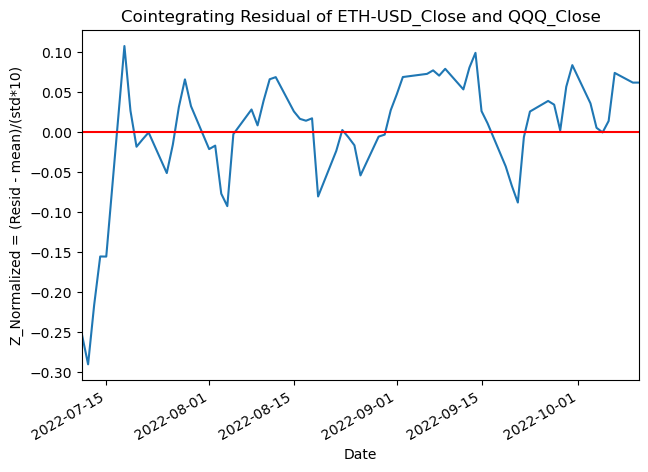

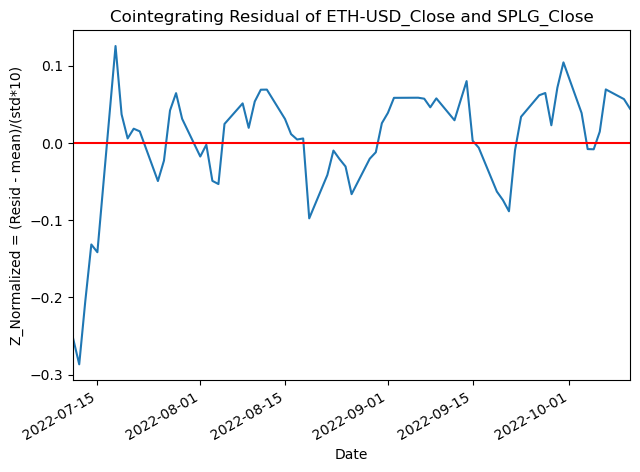

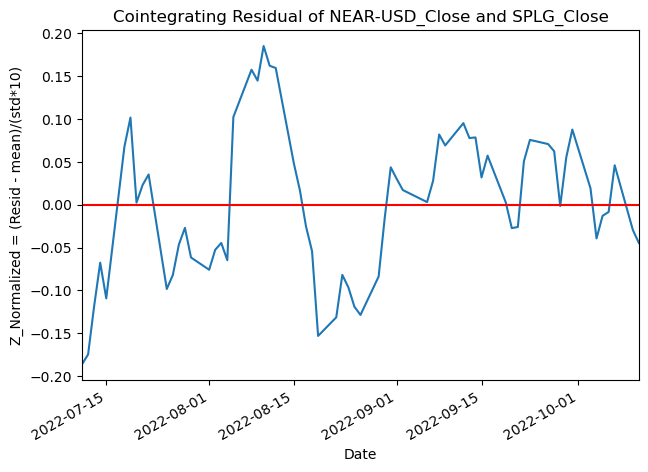

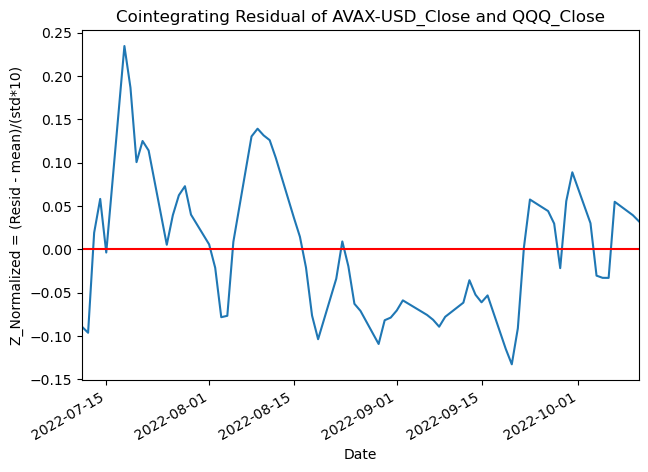

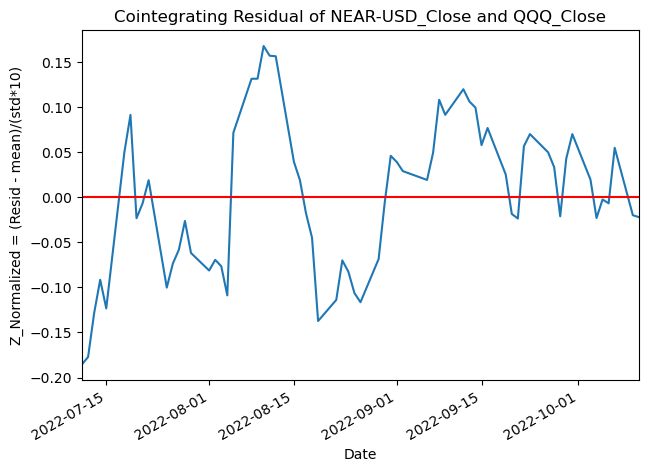

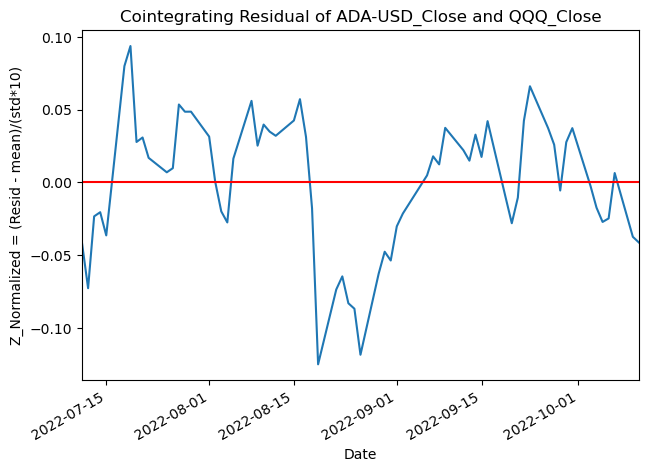

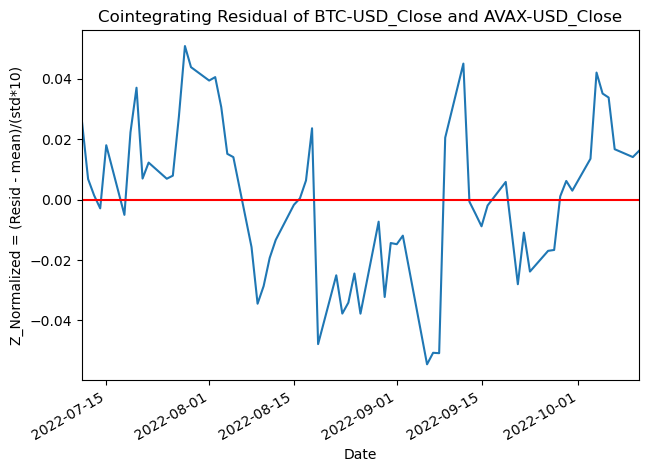

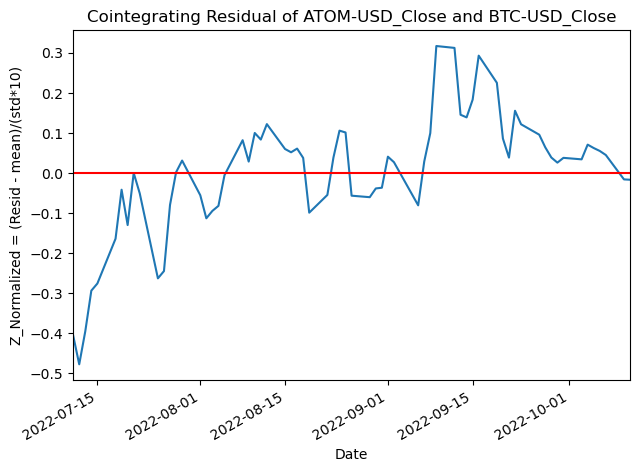

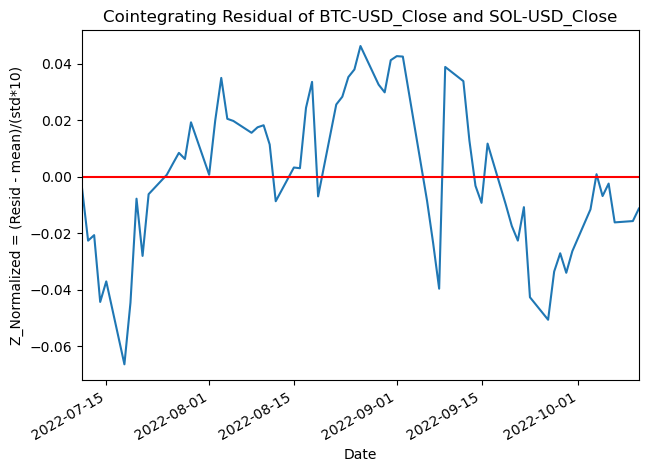

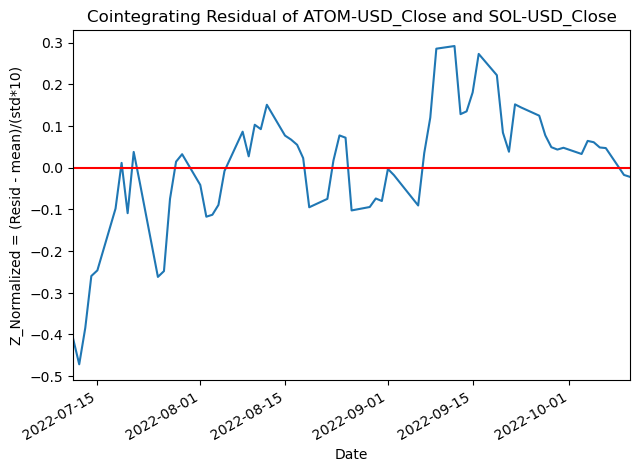

In [153]:
df = po.po_test(data_df.apply(np.log), plot=True)
df